<h1><center><size = "6"><a href = "https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview"> Jigsaw </a> Baseline Models </center></h1>

<center><img src = "https://storage.googleapis.com/kaggle-media/competitions/jigsaw/003-avatar.png"
 width = "150" height = "150"></center>

<br>
<h2><a href="#parameters"> Hyper-Parameters </a></h2>
<h2><a href="#Baseline-Models"> Baseline Models </a></h2>

- <a href="#Model0"> APCNN </a>
- <a href="#Model1"> RCNN </a>
- <a href="#Model2"> D-LSTM </a>
- <a href="#Model3"> Double RCNN </a>
- <a href="#Model4"> LSTM-GRU </a>
- <a href="#Model5"> LSTM-GRU(Attention) </a>
- <a href="#Model6"> Temporal CNN </a>

<h2><a href="#Plots" > Plot Train Loss and Val Loss </a></h2>

In [1]:
import numpy as np, pandas as pd, random as rn, seaborn as sns
import os, gc, re, time
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

start = time.time()

seed = 32
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["OMP_NUM_THREADS"] = "4"
np.random.seed(seed)
rn.seed(seed)

import tensorflow as tf
session_conf = tf.ConfigProto(intra_op_parallelism_threads = 1,
                              inter_op_parallelism_threads = 1)
tf.set_random_seed(seed)
sess = tf.Session(graph = tf.get_default_graph(), config = session_conf)
from keras import backend as K
K.set_session(sess)

import keras.layers as L, keras.initializers as init, keras.optimizers as opti
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.engine.topology import Layer

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

train = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
article_id = train["article_id"]
target = np.where(train["target"] >= 0.5, 1, 0)
aux_target = ["target", "severe_toxicity", "obscene", "identity_attack", "insult", "threat"]

max_len = 220
max_features = 100000
embed_size = 300
embedding_file = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"

Using TensorFlow backend.


## <a id="parameters"> Hyper-Parameters </a>

In [2]:
lr = 0.001
dr = 0.3
rnn_units = 64
cnn_filters = 64
opt = opti.Adam(lr = lr)

model_history = {}

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def visual_model(hist = None):
    plt.figure(figsize = (10, 8))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["train", "val"], loc = "upper left")
    plt.show()

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train["comment_text"], target, test_size = 0.2, 
                                                  random_state = seed, 
                                                  shuffle = True, stratify = target)

In [5]:
tk = Tokenizer(num_words = max_features, lower = True)
tk.fit_on_texts(X_train)
word_index = tk.word_index
train_token = tk.texts_to_sequences(X_train)
val_token = tk.texts_to_sequences(X_val)
X_train = pad_sequences(train_token, maxlen = max_len)
X_val = pad_sequences(val_token, maxlen = max_len)

del train_token, val_token; gc.collect()

0

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir = embedding_file):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_embedding_matrix(word_index, embeddings_index, max_features, lower = True, verbose = True):
    embedding_matrix = np.zeros((max_features, 300))
    for word, i in tqdm(word_index.items(),disable = not verbose):
        if lower:
            word = word.lower()
        if i >= max_features: continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            embedding_vector = embeddings_index["unknown"]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [7]:
embedding_index = load_embeddings()
embedding_matrix = build_matrix(word_index, embedding_index)
del embedding_index; gc.collect()

2000001it [02:44, 12184.42it/s]


0

In [8]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [9]:
'''
https://github.com/titu1994/keras-adabound/blob/master/adabound.py
'''
from keras.optimizers import Optimizer


class AdaBound(Optimizer):
    """AdaBound optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        final_lr: float >= 0. Final learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        gamma: float >= 0. Convergence speed of the bound function.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: Weight decay weight.
        amsbound: boolean. Whether to apply the AMSBound variant of this
            algorithm.
    # References
        - [Adaptive Gradient Methods with Dynamic Bound of Learning Rate]
          (https://openreview.net/forum?id=Bkg3g2R9FX)
        - [Adam - A Method for Stochastic Optimization]
          (https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond]
          (https://openreview.net/forum?id=ryQu7f-RZ)
    """

    def __init__(self, lr=0.001, final_lr=0.1, beta_1=0.9, beta_2=0.999, gamma=1e-3,
                 epsilon=None, decay=0., amsbound=False, weight_decay=0.0, **kwargs):
        super(AdaBound, self).__init__(**kwargs)

        if not 0. <= gamma <= 1.:
            raise ValueError("Invalid `gamma` parameter. Must lie in [0, 1] range.")

        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')

        self.final_lr = final_lr
        self.gamma = gamma

        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsbound = amsbound

        self.weight_decay = float(weight_decay)
        self.base_lr = float(lr)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        # Applies bounds on actual learning rate
        step_size = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                          (1. - K.pow(self.beta_1, t)))

        final_lr = self.final_lr * lr / self.base_lr
        lower_bound = final_lr * (1. - 1. / (self.gamma * t + 1.))
        upper_bound = final_lr * (1. + 1. / (self.gamma * t))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsbound:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            # apply weight decay
            if self.weight_decay != 0.:
                g += self.weight_decay * K.stop_gradient(p)

            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            if self.amsbound:
                vhat_t = K.maximum(vhat, v_t)
                denom = (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                denom = (K.sqrt(v_t) + self.epsilon)

            # Compute the bounds
            step_size_p = step_size * K.ones_like(denom)
            step_size_p_bound = step_size_p / denom
            bounded_lr_t = m_t * K.minimum(K.maximum(step_size_p_bound,
                                                     lower_bound), upper_bound)

            p_t = p - bounded_lr_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'final_lr': float(self.final_lr),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'gamma': float(self.gamma),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'weight_decay': self.weight_decay,
                  'amsbound': self.amsbound}
        base_config = super(AdaBound, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
import six
import copy
from six.moves import zip
from keras.utils.generic_utils import serialize_keras_object
from keras.utils.generic_utils import deserialize_keras_object
from keras.legacy import interfaces

class AdamW(Optimizer):
    """Adam optimizer.
    Default parameters follow those provided in the original paper.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Decoupled weight decay over each update.
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [Optimization for Deep Learning Highlights in 2017](http://ruder.io/deep-learning-optimization-2017/index.html)
        - [Fixing Weight Decay Regularization in Adam](https://arxiv.org/abs/1711.05101)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4,  # decoupled weight decay (1/6)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr # decoupled weight decay (2/6)
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (3/6)
        self.epsilon = epsilon
        self.initial_decay = decay

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        eta_t = lr / self.init_lr # decoupled weight decay (5/6)

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - eta_t * wd * p # decoupled weight decay (6/6)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [11]:
class SWA(Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i, layer in enumerate(self.model.layers):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

## <a id="Baseline-Models"> Baseline Models </a>

In [12]:
def train_predict(nn_model = None):
    model = nn_model
    lr_schedule = LearningRateScheduler(lambda epoch: lr*(0.5**epoch))
    
    model_hist = model.fit(X_train, y_train, batch_size = 1024, epochs = 10,
                           validation_data = (X_val, y_val), verbose = 2, 
                           callbacks = [lr_schedule])
    
    val_pred = model.predict(X_val, batch_size = 1024, verbose = 2)
    print("val val score:", roc_auc_score(y_val, val_pred))
    
    return model_hist

## <a id="Model0"> APCNN </a>

In [13]:
def apcnn(units = rnn_units*2, dr = dr, filters = cnn_filters):
    inp = L.Input(shape = (max_len, ))
    embed_layer = L.Embedding(len(word_index) + 1, embed_size, input_length = max_len,
                              weights = [embedding_matrix], trainable = False)(inp)
    
    x = L.SpatialDropout1D(dr)(embed_layer)
    x1 = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    x2 = L.Conv1D(filters, 1, activation = "relu", kernel_initializer = "glorot_uniform")(x)
    att = Attention(max_len)(x1)
    avg_pool = L.GlobalAveragePooling1D()(x2)
    max_pool = L.GlobalMaxPooling1D()(x2)
    x = L.concatenate([att, avg_pool, max_pool])
    x = L.Dense(filters*2, activation = "relu",
                kernel_initializer = init.glorot_normal(seed = seed))(x)
    
    out = L.Dense(1, activation = "sigmoid",
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = None)
    
    return model

In [14]:
apcnn_model = apcnn()
apcnn_hist = train_predict(nn_model = apcnn_model)
model_history["apcnn"] = apcnn_hist

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 288s - loss: 0.1558 - val_loss: 0.1321
Epoch 2/10
 - 286s - loss: 0.1315 - val_loss: 0.1246
Epoch 3/10
 - 286s - loss: 0.1266 - val_loss: 0.1235
Epoch 4/10
 - 286s - loss: 0.1243 - val_loss: 0.1223
Epoch 5/10
 - 285s - loss: 0.1230 - val_loss: 0.1240
Epoch 6/10
 - 285s - loss: 0.1224 - val_loss: 0.1247
Epoch 7/10
 - 285s - loss: 0.1222 - val_loss: 0.1227
Epoch 8/10
 - 285s - loss: 0.1220 - val_loss: 0.1230
Epoch 9/10
 - 285s - loss: 0.1220 - val_loss: 0.1236
Epoch 10/10
 - 284s - loss: 0.1219 - val_loss: 0.1232
val val score: 0.9615837965161959


## <a id="Model1">RCNN</a>

In [15]:
def rcnn(units = rnn_units*2, dr = dr, filters = cnn_filters):
    inp = L.Input(shape = (max_len, ))
    embed_layer = L.Embedding(len(word_index) + 1, embed_size, input_length = max_len,
                              weights = [embedding_matrix], trainable = False)(inp)
    
    x = L.SpatialDropout1D(dr)(embed_layer)
    x = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    x = L.Conv1D(filters, 1, activation = "relu", kernel_initializer = "glorot_uniform")(x)
    avg_pool = L.GlobalAveragePooling1D()(x)
    max_pool = L.GlobalMaxPooling1D()(x)
    x = L.concatenate([avg_pool, max_pool])
    x = L.Dense(filters*2, activation = "relu",
                kernel_initializer = init.glorot_normal(seed = seed))(x)
    x = L.Dropout(0.1, seed = seed)(x)
    
    out = L.Dense(1, activation = "sigmoid",
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = None)
    
    return model

In [16]:
rcnn_model = rcnn()
rcnn_hist = train_predict(nn_model = rcnn_model)
model_history["rcnn"] = rcnn_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 273s - loss: 0.1514 - val_loss: 0.1277
Epoch 2/10
 - 272s - loss: 0.1282 - val_loss: 0.1244
Epoch 3/10
 - 273s - loss: 0.1244 - val_loss: 0.1207
Epoch 4/10
 - 273s - loss: 0.1223 - val_loss: 0.1212
Epoch 5/10
 - 273s - loss: 0.1215 - val_loss: 0.1200
Epoch 6/10
 - 274s - loss: 0.1210 - val_loss: 0.1203
Epoch 7/10
 - 274s - loss: 0.1206 - val_loss: 0.1201
Epoch 8/10
 - 274s - loss: 0.1205 - val_loss: 0.1200
Epoch 9/10
 - 274s - loss: 0.1204 - val_loss: 0.1201
Epoch 10/10
 - 273s - loss: 0.1203 - val_loss: 0.1201
val val score: 0.9621998713712177


## <a id="Model2">D-LSTM</a>

In [17]:
def d_lstm(units = rnn_units, dr = dr):
    inp = L.Input(shape = (max_len, ))
    embed_layer = L.Embedding(len(word_index) + 1, embed_size, input_length = max_len, 
                             weights = [embedding_matrix], trainable = False)(inp)
    x = L.SpatialDropout1D(dr)(embed_layer)
    x = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    x = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    
    max_pool = L.GlobalMaxPooling1D()(x)
    avg_pool = L.GlobalAveragePooling1D()(x)
    x = L.concatenate([max_pool, avg_pool])
    
    out = L.Dense(1, activation = "sigmoid",
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = None)
    
    return model

In [18]:
d_lstm_model = d_lstm()
d_lstm_hist = train_predict(nn_model = d_lstm_model)
model_history["d_lstm"] = d_lstm_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 254s - loss: 0.1444 - val_loss: 0.1244
Epoch 2/10
 - 252s - loss: 0.1260 - val_loss: 0.1203
Epoch 3/10
 - 252s - loss: 0.1227 - val_loss: 0.1196
Epoch 4/10
 - 253s - loss: 0.1211 - val_loss: 0.1185
Epoch 5/10
 - 253s - loss: 0.1204 - val_loss: 0.1191
Epoch 6/10
 - 252s - loss: 0.1201 - val_loss: 0.1187
Epoch 7/10
 - 251s - loss: 0.1199 - val_loss: 0.1185
Epoch 8/10
 - 252s - loss: 0.1196 - val_loss: 0.1183
Epoch 9/10
 - 254s - loss: 0.1197 - val_loss: 0.1182
Epoch 10/10
 - 253s - loss: 0.1198 - val_loss: 0.1183
val val score: 0.9628013738825395


## <a id="Model3"> Double RCNN </a>

In [19]:
def d_rcnn(units = rnn_units, dr = dr, filters = cnn_filters):
    inp = L.Input(shape = (max_len, ))
    embed_layer = L.Embedding(len(word_index) + 1, embed_size, input_length = max_len, 
                             weights = [embedding_matrix], trainable = False)(inp)
    x = L.SpatialDropout1D(dr)(embed_layer)
    x1 = L.Bidirectional(L.CuDNNGRU(rnn_units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    x1 = L.Conv1D(filters, 3, activation = "relu", kernel_initializer = "glorot_uniform")(x1)
    max_pool1 = L.GlobalMaxPooling1D()(x1)
    avg_pool1 = L.GlobalAveragePooling1D()(x1)
    
    x2 = L.Bidirectional(L.CuDNNGRU(rnn_units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed),
                                    return_sequences = True))(x)
    x2 = L.Conv1D(filters, 2, activation = "relu", kernel_initializer = "glorot_uniform")(x2)
    max_pool2 = L.GlobalMaxPooling1D()(x2)
    avg_pool2 = L.GlobalAveragePooling1D()(x2)
    
    x = L.concatenate([max_pool1, avg_pool1, max_pool2, avg_pool2])
    
    out = L.Dense(1, activation = "sigmoid",
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = None)
    
    return model

In [20]:
d_rcnn_model = d_rcnn()
d_rcnn_hist = train_predict(nn_model = d_rcnn_model)
model_history["d_rcnn"] = d_rcnn_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 280s - loss: 0.1441 - val_loss: 0.1260
Epoch 2/10
 - 277s - loss: 0.1273 - val_loss: 0.1215
Epoch 3/10
 - 276s - loss: 0.1236 - val_loss: 0.1209
Epoch 4/10
 - 277s - loss: 0.1217 - val_loss: 0.1220
Epoch 5/10
 - 275s - loss: 0.1208 - val_loss: 0.1203
Epoch 6/10
 - 276s - loss: 0.1205 - val_loss: 0.1202
Epoch 7/10
 - 274s - loss: 0.1200 - val_loss: 0.1204
Epoch 8/10
 - 277s - loss: 0.1200 - val_loss: 0.1202
Epoch 9/10
 - 274s - loss: 0.1200 - val_loss: 0.1204
Epoch 10/10
 - 278s - loss: 0.1198 - val_loss: 0.1204
val val score: 0.9620302196023098


## <a id="Model4"> LSTM-GRU </a>

In [21]:
def lstm_gru(dr = dr, units = rnn_units):
    inp = L.Input(shape = (max_len, ), dtype = "int32")
    embed = L.Embedding(*embedding_matrix.shape, weights = [embedding_matrix], 
                        input_length = max_len, trainable = False)(inp)
    x = L.SpatialDropout1D(dr)(embed)
    x = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed), 
                                    return_sequences = True))(x)
    x, x_h, x_c = L.Bidirectional(L.CuDNNGRU(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                             recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed), 
                                             return_state = True,
                                             return_sequences = True))(x)
    
    avg_pool = L.GlobalAveragePooling1D()(x)
    max_pool = L.GlobalMaxPooling1D()(x)
    
    x = L.concatenate([x_h, avg_pool, max_pool])
    
    out = L.Dense(1, activation = "sigmoid", 
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = opt,
                  metrics = None)
    return model

In [22]:
lstm_gru_model = lstm_gru()
lstm_gru_hist = train_predict(nn_model = lstm_gru_model)
model_history["lstm_gru"] = lstm_gru_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 252s - loss: 0.1396 - val_loss: 0.1246
Epoch 2/10
 - 250s - loss: 0.1245 - val_loss: 0.1194
Epoch 3/10
 - 250s - loss: 0.1215 - val_loss: 0.1185
Epoch 4/10
 - 251s - loss: 0.1198 - val_loss: 0.1178
Epoch 5/10
 - 251s - loss: 0.1193 - val_loss: 0.1178
Epoch 6/10
 - 251s - loss: 0.1188 - val_loss: 0.1177
Epoch 7/10
 - 250s - loss: 0.1187 - val_loss: 0.1178
Epoch 8/10
 - 251s - loss: 0.1185 - val_loss: 0.1179
Epoch 9/10
 - 253s - loss: 0.1185 - val_loss: 0.1176
Epoch 10/10
 - 254s - loss: 0.1186 - val_loss: 0.1177
val val score: 0.9633094904459466


## <a id="Model5"> LSTM-GRU(Attention) </a>

In [23]:
def lstm_gru_att(dr = dr, units = rnn_units):
    inp = L.Input(shape = (max_len, ), dtype = "int32")
    embed = L.Embedding(*embedding_matrix.shape, weights = [embedding_matrix], 
                        input_length = max_len, trainable = False)(inp)
    x = L.SpatialDropout1D(dr)(embed)
    x = L.Bidirectional(L.CuDNNLSTM(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                    recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed), 
                                    return_sequences = True))(x)
    x, x_h, x_c = L.Bidirectional(L.CuDNNGRU(units, kernel_initializer = init.glorot_normal(seed = seed), 
                                             recurrent_initializer = init.orthogonal(gain = 1.0, seed = seed), 
                                             return_state = True,
                                             return_sequences = True))(x)
    
    att = Attention(max_len)(x)
    x = L.concatenate([x_h, att])
    
    out = L.Dense(1, activation = "sigmoid", 
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = opt,
                  metrics = None)
    return model

In [24]:
lstm_gru_att_model = lstm_gru_att()
lstm_gru_att_hist = train_predict(nn_model = lstm_gru_att_model)
model_history["lstm_gru_att"] = lstm_gru_att_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 258s - loss: 0.1419 - val_loss: 0.1226
Epoch 2/10
 - 256s - loss: 0.1254 - val_loss: 0.1197
Epoch 3/10
 - 255s - loss: 0.1224 - val_loss: 0.1189
Epoch 4/10
 - 255s - loss: 0.1207 - val_loss: 0.1181
Epoch 5/10
 - 256s - loss: 0.1203 - val_loss: 0.1180
Epoch 6/10
 - 256s - loss: 0.1197 - val_loss: 0.1180
Epoch 7/10
 - 256s - loss: 0.1196 - val_loss: 0.1179
Epoch 8/10
 - 255s - loss: 0.1193 - val_loss: 0.1180
Epoch 9/10
 - 257s - loss: 0.1194 - val_loss: 0.1179
Epoch 10/10
 - 257s - loss: 0.1195 - val_loss: 0.1179
val val score: 0.9630595376359761


## <a id="Model6"> Temporal CNN </a>

In [25]:
import keras.backend as K
import keras.layers
from keras import optimizers
from keras.engine.topology import Layer
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model
from typing import List, Tuple


def channel_normalization(x):
    # type: (Layer) -> Layer
    """ Normalize a layer to the maximum activation
    This keeps a layers values between zero and one.
    It helps with relu's unbounded activation
    Args:
        x: The layer to normalize
    Returns:
        A maximal normalized layer
    """
    max_values = K.max(K.abs(x), 2, keepdims=True) + 1e-5
    out = x / max_values
    return out


def wave_net_activation(x):
    # type: (Layer) -> Layer
    """This method defines the activation used for WaveNet
    described in https://deepmind.com/blog/wavenet-generative-model-raw-audio/
    Args:
        x: The layer we want to apply the activation to
    Returns:
        A new layer with the wavenet activation applied
    """
    tanh_out = Activation('tanh')(x)
    sigm_out = Activation('sigmoid')(x)
    return keras.layers.multiply([tanh_out, sigm_out])


def residual_block(x, s, i, activation, nb_filters, kernel_size, padding, dropout_rate=0, name=''):
    # type: (Layer, int, int, str, int, int, float, str) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        s: The stack index i.e. which stack in the overall TCN
        i: The dilation power of 2 we are using for this residual block
        activation: The name of the type of activation to use
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        name: Name of the model. Useful when having multiple TCN.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """

    original_x = x
    conv = Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding=padding,
                  name=name + '_dilated_conv_%d_tanh_s%d' % (i, s))(x)
    if activation == 'norm_relu':
        x = Activation('relu')(conv)
        x = Lambda(channel_normalization)(x)
    elif activation == 'wavenet':
        x = wave_net_activation(conv)
    else:
        x = Activation(activation)(conv)

    x = SpatialDropout1D(dropout_rate, name=name + '_spatial_dropout1d_%d_s%d_%f' % (i, s, dropout_rate))(x)

    # 1x1 conv.
    x = Convolution1D(nb_filters, 1, padding='same')(x)
    res_x = keras.layers.add([original_x, x])
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        # print(f'Updated dilations from {dilations} to {new_dilations} because of backwards compatibility.')
        return new_dilations


class TCN(Layer):
    """Creates a TCN layer.
        Args:
            input_layer: A tensor of shape (batch_size, timesteps, input_dim).
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            activation: The activations to use (norm_relu, wavenet, relu...).
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation='norm_relu',
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=True,
                 name='tcn'):
        super().__init__()
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.activation = activation
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.padding = padding

        # backwards incompatibility warning.
        # o = tcn.TCN(i, return_sequences=False) =>
        # o = tcn.TCN(return_sequences=False)(i)

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' paddings are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(i, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(i)')
            print('Second solution is to pip install keras-tcn==2.1.2 to downgrade.')
            raise Exception()

    def __call__(self, inputs):
        if self.dilations is None:
            self.dilations = [1, 2, 4, 8, 16, 32]
        x = inputs
        x = Convolution1D(self.nb_filters, 1, padding=self.padding, name=self.name + '_initial_conv')(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for i in self.dilations:
                x, skip_out = residual_block(x, s, i, self.activation, self.nb_filters,
                                             self.kernel_size, self.padding, self.dropout_rate, name=self.name)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        x = Activation('relu')(x)

        if not self.return_sequences:
            output_slice_index = -1
            x = Lambda(lambda tt: tt[:, output_slice_index, :])(x)
        return x

In [26]:
def temporal_cnn(dr = dr, units = rnn_units):
    inp = L.Input(shape = (max_len, ), dtype = "int32")
    embed = L.Embedding(*embedding_matrix.shape, weights = [embedding_matrix], 
                        input_length = max_len, trainable = False)(inp)
    x = L.SpatialDropout1D(dr)(embed)
    x1 = TCN(units, return_sequences = True, dilations = [1, 2, 4, 8, 16], name = "tcn1_forward")(x)
    x2 = Lambda(lambda z: K.reverse(z, axes = -1))(x)
    x2 = TCN(units, return_sequences = True, activation = "wavenet", name = "tnc1_backward")(x2)
    x = L.add([x1, x2])
    
    x1 = TCN(units, return_sequences = True, dilations = [1, 2, 4, 8, 16], name = "tcn2_forward")(x)
    x2 = Lambda(lambda z: K.reverse(z, axes = -1))(x)
    x2 = TCN(units, return_sequences = True, activation = "wavenet", name = "tnc2_backward")(x2)
    x = L.add([x1, x2])
    
    avg_pool = L.GlobalAveragePooling1D()(x)
    max_pool = L.GlobalMaxPooling1D()(x)
    
    x = L.concatenate([avg_pool, max_pool])
    out = L.Dense(1, activation = "sigmoid", 
                  kernel_initializer = init.glorot_normal(seed = seed))(x)
    
    model = Model(inputs = inp, outputs = out)
    model.compile(loss = "binary_crossentropy", 
                  optimizer = opt,
                  metrics = None)
    return model

In [27]:
temporal_cnn_model = temporal_cnn()
temporal_cnn_hist = train_predict(nn_model = temporal_cnn_model)
model_history["temporal_cnn"] = temporal_cnn_hist

Train on 1443899 samples, validate on 360975 samples
Epoch 1/10
 - 602s - loss: 0.1598 - val_loss: 0.1381
Epoch 2/10
 - 593s - loss: 0.1349 - val_loss: 0.1304
Epoch 3/10
 - 593s - loss: 0.1302 - val_loss: 0.1260
Epoch 4/10
 - 593s - loss: 0.1280 - val_loss: 0.1296
Epoch 5/10
 - 593s - loss: 0.1268 - val_loss: 0.1297
Epoch 6/10
 - 593s - loss: 0.1260 - val_loss: 0.1268
Epoch 7/10
 - 593s - loss: 0.1256 - val_loss: 0.1279
Epoch 8/10
 - 593s - loss: 0.1257 - val_loss: 0.1271
Epoch 9/10
 - 593s - loss: 0.1255 - val_loss: 0.1276
Epoch 10/10
 - 594s - loss: 0.1254 - val_loss: 0.1275
val val score: 0.9583383504425238


## <a id="Plots"> Plot Train Loss and Val Loss </a>

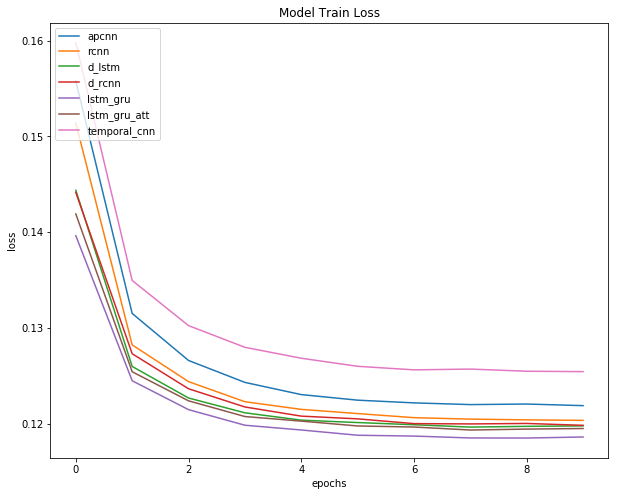

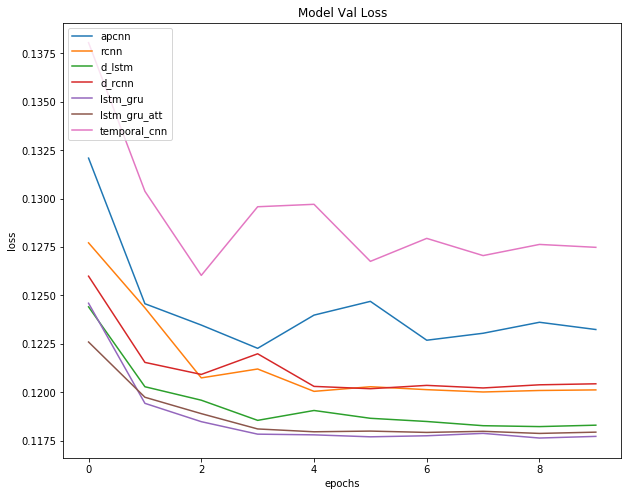

In [28]:
plt.figure(figsize = (10, 8))
for hist in model_history: 
    plt.plot(model_history[hist].history["loss"])
plt.title("Model Train Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(model_history.keys(), loc = "upper left")
plt.savefig("Train_Loss.png")
plt.show()

plt.figure(figsize = (10, 8))
for hist in model_history: 
    plt.plot(model_history[hist].history["val_loss"])
plt.title("Model Val Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(model_history.keys(), loc = "upper left")
plt.savefig("Val_Loss.png")
plt.show()